In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import gc
import sys
sys.path.append('../')

from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from IPython.display import HTML, display
from sklearn import metrics
import traceback 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

MERED = "merged"
PATH = "../../../data/titanic/"
#PATH = "../../data/home-credit-default-risk/"

/home/max/anaconda3/envs/fastai-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/max/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
ls {PATH}

gender_submission.csv  test.csv  train.csv


In [82]:
file_names = ['train', 'test']
tables = [pd.read_csv(f'{PATH}{file_name}.csv',low_memory=False) for file_name in file_names]

In [31]:
for t in tables:
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(t.head())

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,female,22.0,1,1,3101298,12.2875,NaN,S


In [32]:
for t in tables:
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(DataFrameSummary(t).summary())

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891,891,891,NaN,714,891,891,NaN,891,NaN,NaN
mean,446,0.383838,2.30864,NaN,29.6991,0.523008,0.381594,NaN,32.2042,NaN,NaN
std,257.354,0.486592,0.836071,NaN,14.5265,1.10274,0.806057,NaN,49.6934,NaN,NaN
min,1,0,1,NaN,0.42,0,0,NaN,0,NaN,NaN
25%,223.5,0,2,NaN,20.125,0,0,NaN,7.9104,NaN,NaN
50%,446,0,3,NaN,28,0,0,NaN,14.4542,NaN,NaN
75%,668.5,1,3,NaN,38,1,0,NaN,31,NaN,NaN
max,891,1,3,NaN,80,8,6,NaN,512.329,NaN,NaN
counts,891,891,891,891,714,891,891,891,891,204,889
uniques,891,2,3,2,88,7,7,681,248,147,3


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418,418,NaN,332,418,418,NaN,417,NaN,NaN
mean,1100.5,2.26555,NaN,30.2726,0.447368,0.392344,NaN,35.6272,NaN,NaN
std,120.81,0.841838,NaN,14.1812,0.89676,0.981429,NaN,55.9076,NaN,NaN
min,892,1,NaN,0.17,0,0,NaN,0,NaN,NaN
25%,996.25,1,NaN,21,0,0,NaN,7.8958,NaN,NaN
50%,1100.5,3,NaN,27,0,0,NaN,14.4542,NaN,NaN
75%,1204.75,3,NaN,39,1,0,NaN,31.5,NaN,NaN
max,1309,3,NaN,76,8,9,NaN,512.329,NaN,NaN
counts,418,418,418,332,418,418,418,417,91,418
uniques,418,3,2,79,7,8,363,169,76,3


In [4]:
def print_score(m):
    print(m.score(X_train, y_train), m.score(X_valid, y_valid))

In [5]:
train, test = tables

In [10]:
train.shape, test.shape

((891, 12), (418, 11))

In [36]:
cat_vars = ['Sex', 'Ticket', 'Cabin', 'Embarked', 'SibSp', 'Parch', 'Pclass',]
contin_vars = ['Fare', 'Age']

index = 'PassengerId'
dep = 'Survived'

In [83]:
joined = train[cat_vars+contin_vars+[dep, index]].copy()

In [84]:
test[dep] = 0
joined_test = test[cat_vars+contin_vars+[dep, index]].copy()

In [85]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [86]:
for v in cat_vars: joined_test[v] = joined_test[v].astype('category').cat.as_ordered()

In [87]:
joined.set_index(joined.PassengerId, inplace=True)
joined_test.set_index(joined_test.PassengerId, inplace=True)

In [92]:
apply_cats(joined_test, joined)

In [93]:
df, y, nas = proc_df(joined, dep)

In [94]:
df_test, _, nas = proc_df(joined_test, dep, na_dict=nas)

In [95]:
df_test.drop(['Fare_na'], axis=1, inplace=True)

KeyError: "['Fare_na'] not found in axis"

In [89]:
joined.drop(['PassengerId'], axis=1, inplace=True)

In [90]:
joined_test.drop(['PassengerId'], axis=1, inplace=True)

In [18]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 418  # same as Kaggle's test set size
n_trn = len(df) - n_valid

In [96]:
set_rf_samples(750)

In [97]:
y_train, y_valid = split_vals(y, n_trn)

In [98]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=10, max_features=0.5, n_jobs=-1, oob_score=True)
X_train, X_valid = split_vals(df, n_trn)
m.fit(X_train, y_train)
print_score(m)

0.864693446088795 0.8157894736842105


In [64]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [99]:
fi = rf_feat_importance(m, df); fi

,cols,imp
0,Sex,0.547906
7,Fare,0.098970
1,Ticket,0.084673
8,Age,0.076489
2,Cabin,0.068131
6,Pclass,0.064471
3,Embarked,0.030202
4,SibSp,0.019473
5,Parch,0.007804
9,Age_na,0.001882


In [100]:
fi = rf_feat_importance(m, df)

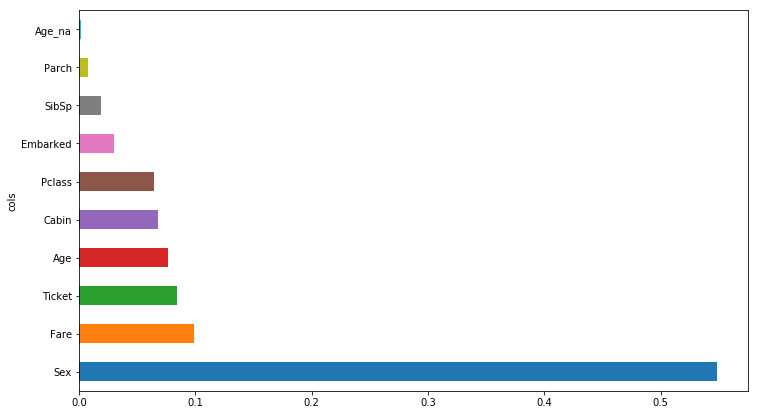

In [101]:
plot_fi(fi)

In [28]:
from scipy.cluster import hierarchy as hc

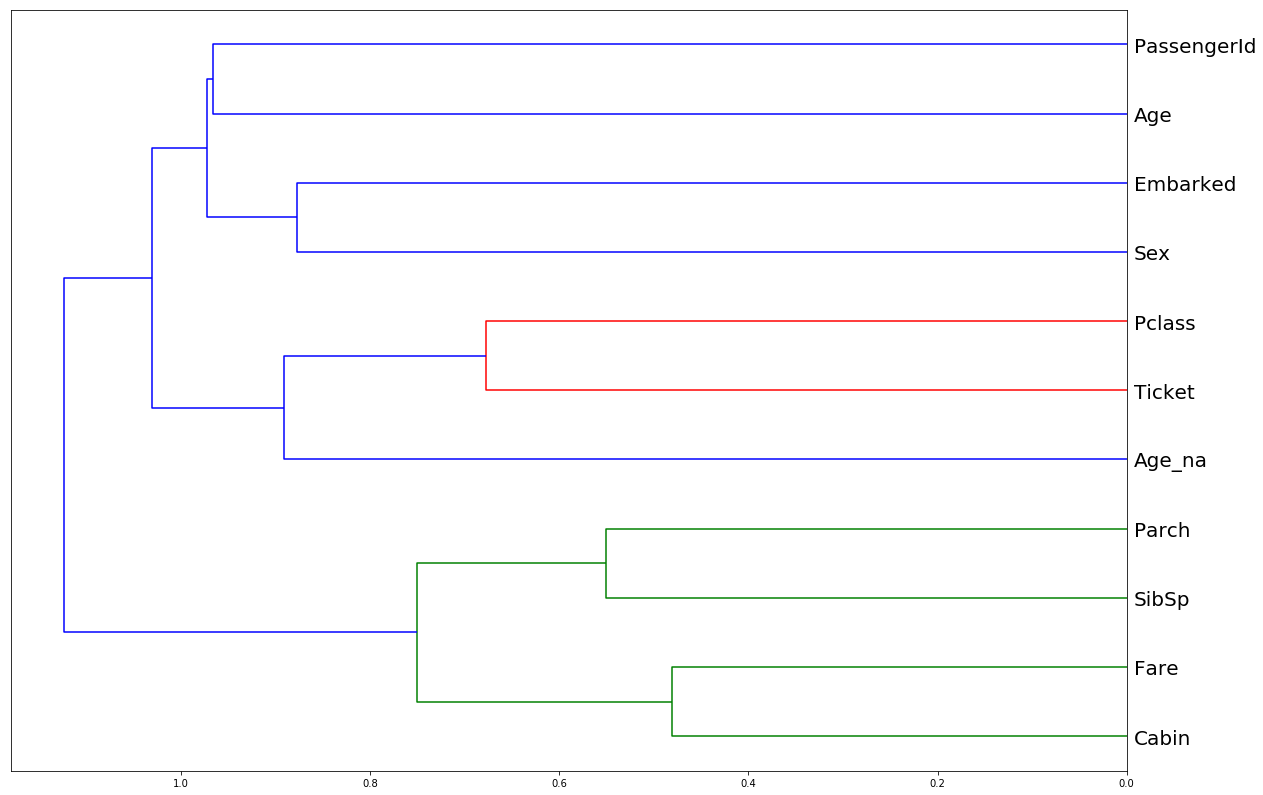

In [68]:
corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(20,14))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=20)
plt.show()

In [69]:
print_score(m)

0.8604651162790697 0.8110047846889952


In [102]:
n_left = 8
df_keep = df[fi[:n_left].cols].copy()
df_test_keep = df_test[fi[:n_left].cols].copy()

In [103]:
reset_rf_samples()

In [107]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
X_train, X_valid = split_vals(df_keep, n_trn)
m.fit(X_train, y_train)
print_score(m)

0.8816067653276956 0.8229665071770335


# Confidence based on tree variance

In [289]:
def get_preds(t): return t.predict(X_valid)
preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

(0.95, 0.2179449471770337)

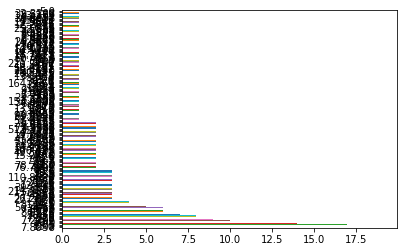

In [295]:
x = X_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Fare.value_counts().plot.barh();

# Partial dependence

In [322]:
set_rf_samples(600)

In [323]:
df_trn2, y_trn, nas = proc_df(joined, dep, max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train);

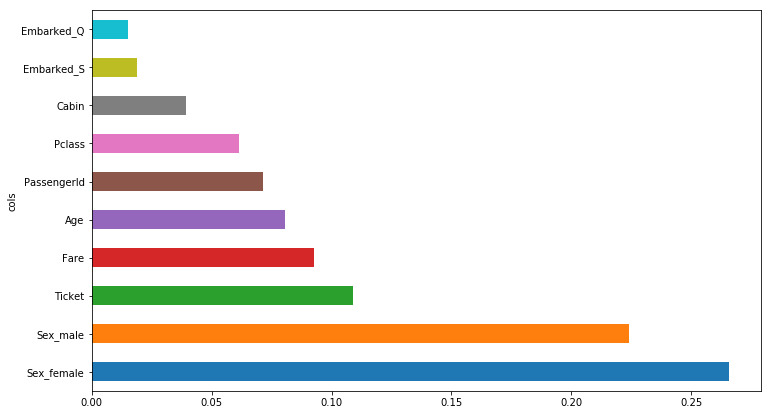

In [324]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

In [ ]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

# Result

In [77]:
pred = m.predict(df_test_keep)

In [78]:
pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, ..., 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0])

In [79]:
df_test_i = df_test.reset_index()

ValueError: cannot insert PassengerId, already exists

In [80]:
submission = pd.DataFrame({'PassengerId': df_test_i['PassengerId'],
              'Survived': pred})
submission.to_csv('submission.csv', index=False)

NameError: name 'df_test_i' is not defined

In [127]:
FileLink(f'submission.csv')

/home/max/Documents/Projects.githab/fastai/fastai_learn/submission.csv